In [1]:
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
%load_ext autoreload
%autoreload 2

#os.environ["CUDA_VISIBLE_DEVICES"]="1"

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt
% matplotlib inline

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)



In [2]:
# import our command line tools
from sketch_rnn_train import *
from model_mod import *
from utils import *
from rnn import *

In [3]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, color="black", doGradient=False, endColor="black", factor=0.2, svg_filename = 'svg/sample.svg'):
    tf.gfile.MakeDirs(os.path.dirname(svg_filename))
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in xrange(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    
    the_color = color
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))
    

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]

  #for each reconstruction
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

In [4]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

#latent vector to stroke
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m, _, _ = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes


In [5]:
model_dir = 'checkpoint_path/cat'
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)


INFO:tensorflow:Loading model checkpoint_path/cat/vector-200000.
INFO:tensorflow:Restoring parameters from checkpoint_path/cat/vector-200000


In [7]:
# randomly unconditionally generate 10 examples from test set
data_dir = 'datasets/'
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir)


NotFoundError: cat.full.npz/model_config.json

In [8]:
def draw_strokes_gradient(data, n, n_examples, factor = .2):
    
    x = 0
    y = 0
    s = 0
    imagex = [[x]]
    imagey = [[y]]
    for i in range(len(data)):
        x += data[i][0]*factor
        y += data[i][1]*factor
        imagex[s].append(x)
        imagey[s].append(y)
        if data[i][2] == 1:
            s += 1
            imagex.append([])
            imagey.append([])
    
    n_strokes = len(imagex)
    plt.subplot(1,n_examples,n+1)
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.axis("equal")
    colors = [(.1 + j*.9/n_strokes, .15, 1 - j*.9/n_strokes) for j in range(n_strokes)]
    for j in range(n_strokes):
        plt.plot(imagex[j], imagey[j], color = colors[j], linewidth = 1)


N =  8
ims = []

train_set = load_dataset(data_dir, model_params, inference_mode=True)

fig = plt.subplots(nrows=1, ncols=N, figsize=(6,1))
for i in range(N):
    im = train_set.strokes[10]
    #im = test_set.random_sample()
    ims.append([im, [0, i]])
    draw_strokes_gradient(im, i, N)
# plt.savefig('results/progress/mosquito_data.pdf', bbox_inches='tight')

NameError: name 'model_params' is not defined

INFO:tensorflow:Loading model checkpoint_path/cat/vector-200000.
INFO:tensorflow:Restoring parameters from checkpoint_path/cat/vector-200000


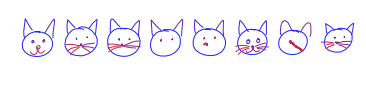

In [14]:
# randomly unconditionally generate N examples
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)
fig = plt.subplots(nrows=1, ncols=N, figsize=(6,1))
reconstructions = []
for i in range(N):
    sample_strokes, m, hidden_states, final_x = sample(sess, sample_model, temperature=.2)
    strokes = to_normal_strokes(sample_strokes)
    draw_strokes_gradient(strokes, i, N)
#plt.savefig('results/progress/mosquito_recon_5000.pdf', bbox_inches='tight')



100


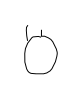

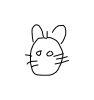

In [16]:
#DRAW FIRST PART OF SKETCH
#get some sample strokes
sample_strokes_1, m, hidden_states, final_x = sample(sess, sample_model, seq_len=100, temperature=0.8) #final_state,final_x
print(len(sample_strokes_1))
n_strokes = np.round(len(sample_strokes_1)/3)
sample_strokes_part = sample_strokes_1[:n_strokes]
strokes_part = to_normal_strokes(sample_strokes_part)
sketch_part = draw_strokes(strokes_part, factor=0.2, svg_filename = 'svg/test.svg')
strokes_full = to_normal_strokes(sample_strokes_1)
sketch_full = [draw_strokes(strokes_full, factor=0.2), [0, 0]]

final_state = hidden_states[n_strokes]

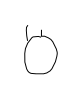

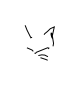

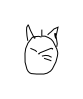

In [ ]:
# Encode generated strokes to a hidden state h
strokes_0 = sample_strokes_part # dx, dx, p1, p2, p3

# h_1 = sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes_0], eval_model.sequence_lengths: seq_len})[0]
reconstructions = []
N = 8
for i in range(N):
    sample_strokes_2, m, _, _ = sample(sess=sess, model=sample_model, seq_len=250, temperature=0.75, prev_state = final_state)
    strokes_2 = to_normal_strokes(sample_strokes_2)
    all_strokes_big = np.concatenate((strokes_0,sample_strokes_2),axis=0)
    all_strokes = to_normal_strokes(all_strokes_big)
    if i == 0:
        sketch_0 = [draw_strokes(strokes_part, factor=0.2), [0, 0]]
        sketch_1 = [draw_strokes(strokes_2, factor=0.2),[0, 1]]
        sketch_2 = [draw_strokes(all_strokes, factor=0.2),[0, 1]]
    
    reconstructions.append([all_strokes, [0, i]])
    
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid, factor=0.18, svg_filename = 'svg/test.svg')

INFO:tensorflow:Model using gpu.


INFO:tensorflow:Model using gpu.


INFO:tensorflow:Input dropout mode = False.


INFO:tensorflow:Input dropout mode = False.


INFO:tensorflow:Output dropout mode = False.


INFO:tensorflow:Output dropout mode = False.


INFO:tensorflow:Recurrent dropout mode = True.


INFO:tensorflow:Recurrent dropout mode = True.


INFO:tensorflow:Model using gpu.


INFO:tensorflow:Model using gpu.


INFO:tensorflow:Input dropout mode = 0.


INFO:tensorflow:Input dropout mode = 0.


INFO:tensorflow:Output dropout mode = 0.


INFO:tensorflow:Output dropout mode = 0.


INFO:tensorflow:Recurrent dropout mode = 0.


INFO:tensorflow:Recurrent dropout mode = 0.


INFO:tensorflow:Model using gpu.


INFO:tensorflow:Model using gpu.


INFO:tensorflow:Input dropout mode = 0.


INFO:tensorflow:Input dropout mode = 0.


INFO:tensorflow:Output dropout mode = 0.


INFO:tensorflow:Output dropout mode = 0.


INFO:tensorflow:Recurrent dropout mode = 0.


INFO:tensorflow:Recurrent dropout mode = 0.


INFO:tensorflow:Loading model checkpoint_path/broccoli/vector-185000.


INFO:tensorflow:Loading model checkpoint_path/broccoli/vector-185000.


INFO:tensorflow:Restoring parameters from checkpoint_path/broccoli/vector-185000


INFO:tensorflow:Restoring parameters from checkpoint_path/broccoli/vector-185000


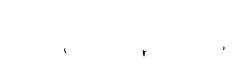

In [17]:
# Now try to switch the class
model_dir = 'checkpoint_path/broccoli'
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

# randomly unconditionally generate examples
reconstructions = []
for i in range(3):
    reconstructions.append([decode(temperature=0.2, draw_mode=False), [0, i]])
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)


33


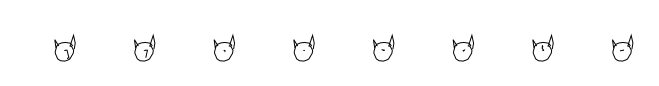

In [15]:
# encode incomplete strokes in a hidden state
_, hidden_states = get_hidden_states(sess=sess, model=sample_model, input_strokes = strokes_0)
print(len(hidden_states))

input_state = hidden_states[-1]

reconstructions = []
for i in range(N):
    sample_strokes_3, _, _, _ = sample(sess=sess, model=sample_model, temperature=0.5, prev_state = input_state)
    strokes_3 = to_normal_strokes(sample_strokes_3)
    all_strokes_big = np.concatenate((sample_strokes_part,sample_strokes_3),axis=0)
    all_strokes = to_normal_strokes(all_strokes_big)
    
    reconstructions.append([all_strokes, [0, i]])
    
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid, svg_filename = 'svg/test.svg')